## To Do list
- 0. 데이터 parquet 형식으로 변환 및 로드
- 1. 데이터 전처리(train,test dataset에서 모두 진행)
    - ID, Cancelled, Diverted 제거
    - Estimated_Departure_Time, Estimated_Arrival_Time 시와 분으로 나눠 볼 필요는 있을 듯
    - Origin_State, Destination_State를 Origin_Airport와 Destination_Airport를 기반으로 결측치 채워주기
    - 이후, Origin_Airport, Destination_Airport 제거
    - Distance log1p 스케일링
    - Airline, Carrier_Code(IATA, DOT) 결측치 채우기
- 2. 예측에 도움되는 피쳐 고르기
- 3. 준지도학습 라벨링(train dataset에서 준지도학습 성능체크)
    - Delay있는 데이터 선택 후 검증세트 생성
    - 모델 탐색 및 피처 탐색 후 학습
    - 검증세트 생성 후 준지도학습 라벨링 성능지표 체크

### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

### Read and Convert Data

In [3]:
def convert_parquet(df):
    csv_dir = f'./data/{df}.csv'
    read_df = pd.read_csv(csv_dir)
    read_df.to_parquet(path=f'./data/{df}.parquet')
    del read_df
    gc.collect()
    print(f'{df} Done')

In [4]:
#convert_parquet('train')
#convert_parquet('test')

### Data Preprocessing

ID, Cancelled, Diverted 제거

In [5]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [6]:
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col=0)

In [7]:
train = train.drop(['ID','Cancelled','Diverted'],axis=1)
test = test.drop(['ID','Cancelled','Diverted'],axis=1)

- Estimated_Departure_Time, Estimated_Arrival_Time 시와 분 분리

In [8]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,4,15,NaN,NaN,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,8,15,740.0,1024.0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,9,6,1610.0,1805.0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,7,10,905.0,1735.0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,1,11,900.0,1019.0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [9]:
estimated_time = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']

In [10]:
#estimated_time 컬럼 최다빈도 값으로 결측치 채우기
for i in estimated_time:
    most_freq = train[i].mode()[0]
    train[i] = train[i].fillna(most_freq)
    test[i] = test[i].fillna(most_freq)

In [11]:
train['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2)

0         06
1         07
2         16
3         09
4         09
          ..
999995    09
999996    09
999997    08
999998    16
999999    18
Name: Estimated_Departure_Time, Length: 1000000, dtype: object

In [12]:
for df in [train,test]:
    df['Estimated_Departure_Hour'] = df['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2).astype(int)
    df['Estimated_Departure_Min'] = df['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(2,4).astype(int)

    df['Estimated_Arrival_Hour'] = df['Estimated_Arrival_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2).astype(int)
    df['Estimated_Arrival_Min'] = df['Estimated_Arrival_Time'].astype(int).astype(str).str.zfill(4).str.slice(2,4).astype(int)

In [13]:
train = train.drop(['Estimated_Departure_Time','Estimated_Arrival_Time'],axis=1)
test = test.drop(['Estimated_Departure_Time','Estimated_Arrival_Time'],axis=1)

In [14]:
train.columns

Index(['Month', 'Day_of_Month', 'Origin_Airport', 'Origin_Airport_ID',
       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
       'Carrier_ID(DOT)', 'Tail_Number', 'Delay', 'Estimated_Departure_Hour',
       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
       'Estimated_Arrival_Min'],
      dtype='object')

In [15]:
train = train.reindex(columns=['Month', 'Day_of_Month', 'Estimated_Departure_Hour',
                       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
                       'Estimated_Arrival_Min', 'Origin_Airport', 'Origin_Airport_ID',
                       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
                       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
                       'Carrier_ID(DOT)', 'Tail_Number', 'Delay'])
test = test.reindex(columns=['Month', 'Day_of_Month', 'Estimated_Departure_Hour',
                       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
                       'Estimated_Arrival_Min', 'Origin_Airport', 'Origin_Airport_ID',
                       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
                       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
                       'Carrier_ID(DOT)', 'Tail_Number', 'Delay'])


<AxesSubplot:>

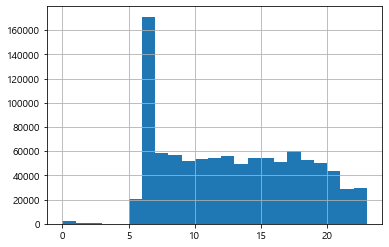

In [16]:
train['Estimated_Departure_Hour'].hist(bins=23)

<AxesSubplot:>

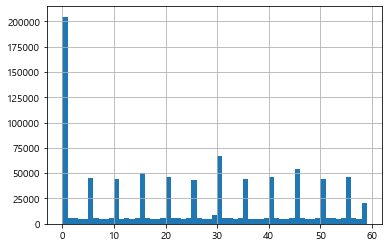

In [17]:
train['Estimated_Departure_Min'].hist(bins=59)

<AxesSubplot:>

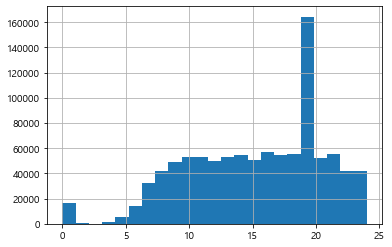

In [18]:
train['Estimated_Arrival_Hour'].hist(bins=23)

<AxesSubplot:>

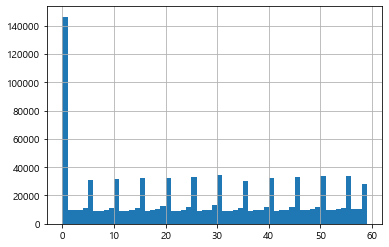

In [19]:
train['Estimated_Arrival_Min'].hist(bins=59)

- Origin_State, Destination_State를 Origin_Airport와 Destination_Airport를 기반으로 결측치 채워주기

train Origin State

In [20]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,4,15,6,0,19,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,8,15,7,40,10,24,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,9,6,16,10,18,5,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,7,10,9,5,17,35,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,1,11,9,0,10,19,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [21]:
train['Origin_Airport'].value_counts()

ORD    50436
ATL    44140
DEN    40300
LAX    31825
DFW    30879
       ...  
ADK       14
GST       13
DLG        9
AKN        8
BFM        6
Name: Origin_Airport, Length: 374, dtype: int64

In [22]:
ord_os = train.loc[train['Origin_Airport'] == 'ORD', 'Origin_State']

train.loc[train['Origin_Airport'] == 'ORD', 'Origin_State'] = ord_os.fillna(
    ord_os.mode()[0])

In [23]:
train.loc[train['Origin_Airport'] == 'ORD', 'Origin_State']

1         Illinois
7         Illinois
32        Illinois
42        Illinois
73        Illinois
            ...   
999919    Illinois
999927    Illinois
999982    Illinois
999990    Illinois
999995    Illinois
Name: Origin_State, Length: 50436, dtype: object

In [24]:
'''
for airport_code in train['Origin_Airport'].unique():
    os_by_oa = train.loc[train['Origin_Airport'] == airport_code, 'Origin_State']
    if os_by_oa.isna().sum():
        train.loc[train['Origin_Airport'] == airport_code,
                  'Origin_State'] = os_by_oa.fillna(os_by_oa.mode()[0])
'''

"\nfor airport_code in train['Origin_Airport'].unique():\n    os_by_oa = train.loc[train['Origin_Airport'] == airport_code, 'Origin_State']\n    if os_by_oa.isna().sum():\n        train.loc[train['Origin_Airport'] == airport_code,\n                  'Origin_State'] = os_by_oa.fillna(os_by_oa.mode()[0])\n"

In [25]:
def fill_state_by_airport(df, origin_or_destination):
    for airport_code in df[f'{origin_or_destination}_Airport'].unique():
        os_by_oa = df.loc[df[f'{origin_or_destination}_Airport'] == airport_code, f'{origin_or_destination}_State']
        if os_by_oa.isna().sum():
            df.loc[df[f'{origin_or_destination}_Airport'] == airport_code,
                    f'{origin_or_destination}_State'] = os_by_oa.fillna(os_by_oa.mode()[0])

In [26]:
fill_state_by_airport(train, 'Origin')

In [27]:
train['Origin_State'].isna().sum()

0

train Destination State

In [28]:
train['Destination_State'].isna().sum()

109079

In [29]:
train['Destination_Airport'].value_counts()

ORD    50171
ATL    43626
DEN    39693
LAX    31936
DFW    30183
       ...  
BFM       11
DLG        8
GST        6
AKN        3
YNG        1
Name: Destination_Airport, Length: 375, dtype: int64

In [30]:
train.loc[train['Destination_Airport'] == 'YNG', 'Destination_State'] = 'Ohio'

In [31]:
'''
for airport_code in train['Destination_Airport'].unique():
    os_by_oa = train.loc[train['Destination_Airport']
                         == airport_code, 'Destination_State']
    if os_by_oa.isna().sum():
        train.loc[train['Destination_Airport'] == airport_code,'Destination_State'] = os_by_oa.fillna(os_by_oa.mode()[0])
'''

"\nfor airport_code in train['Destination_Airport'].unique():\n    os_by_oa = train.loc[train['Destination_Airport']\n                         == airport_code, 'Destination_State']\n    if os_by_oa.isna().sum():\n        train.loc[train['Destination_Airport'] == airport_code,'Destination_State'] = os_by_oa.fillna(os_by_oa.mode()[0])\n"

In [32]:
fill_state_by_airport(train, 'Destination')

In [33]:
train['Destination_State'].isna().sum()

0

test Origin State

In [34]:
test['Origin_Airport'].value_counts()

ORD    53133
ATL    43018
DEN    41126
DFW    33541
LAX    31027
       ...  
DDC        5
AKN        5
GST        3
DEC        2
YNG        1
Name: Origin_Airport, Length: 379, dtype: int64

In [35]:
test.loc[test['Origin_Airport'] == 'DEC', 'Origin_State']

565176    None
607833    None
Name: Origin_State, dtype: object

In [36]:
test.loc[test['Origin_Airport'] == 'DDC', 'Origin_State']

81362     None
272572    None
589822    None
606194    None
849273    None
Name: Origin_State, dtype: object

In [37]:
no_info = []
for airport_code in test['Origin_Airport'].unique():
    test_os = test.loc[test['Origin_Airport']
                       == airport_code, 'Origin_State']
    if (test_os.isna().sum()) == len(test_os):
        no_info.append(airport_code)

In [38]:
no_info

['RIW', 'SHR', 'DDC', 'DEC']

In [39]:
for no_info_oa in no_info:
    test.loc[test['Origin_Airport'] == no_info_oa,
             'Origin_State'] = test['Origin_State'].mode()[0]

In [40]:
'''
for airport_code in test['Origin_Airport'].unique():
    os_by_oa = test.loc[test['Origin_Airport'] == airport_code, 'Origin_State']
    if os_by_oa.isna().sum():
        test.loc[test['Origin_Airport'] == airport_code,
                  'Origin_State'] = os_by_oa.fillna(os_by_oa.mode()[0])
'''

"\nfor airport_code in test['Origin_Airport'].unique():\n    os_by_oa = test.loc[test['Origin_Airport'] == airport_code, 'Origin_State']\n    if os_by_oa.isna().sum():\n        test.loc[test['Origin_Airport'] == airport_code,\n                  'Origin_State'] = os_by_oa.fillna(os_by_oa.mode()[0])\n"

In [41]:
fill_state_by_airport(test, 'Origin')

In [42]:
test['Origin_State'].isna().sum()

0

test Destination State

In [43]:
no_info = []
for airport_code in test['Destination_Airport'].unique():
    test_ds = test.loc[test['Destination_Airport'] == airport_code, 'Destination_State']
    if (test_ds.isna().sum()) == len(test_ds):
        no_info.append(airport_code)

In [44]:
no_info

['RIW', 'SHR', 'DEC']

In [45]:
for no_info_oa in no_info:
    test.loc[test['Destination_Airport'] == no_info_oa,
             'Destination_State'] = test['Destination_State'].mode()[0]

In [46]:
fill_state_by_airport(test, 'Destination')

In [47]:
test['Destination_State'].isna().sum()

0

In [48]:
train['Origin_Airport'].value_counts()

ORD    50436
ATL    44140
DEN    40300
LAX    31825
DFW    30879
       ...  
ADK       14
GST       13
DLG        9
AKN        8
BFM        6
Name: Origin_Airport, Length: 374, dtype: int64

- Origin_Airport_ID, Destination_Airport_ID 제거</br>
(Origin_Airport, Destination_Airport로 LabelEncoding 예정)

In [49]:
train = train.drop(['Origin_Airport_ID','Destination_Airport_ID'],axis=1)
test = test.drop(['Origin_Airport_ID','Destination_Airport_ID'],axis=1)

In [50]:
display(train.shape, test.shape)

(1000000, 16)

(1000000, 16)

- Distance Scaling

<AxesSubplot:>

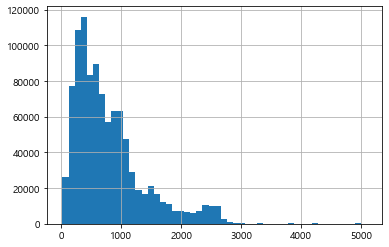

In [51]:
train['Distance'].hist(bins=50)

In [52]:
train['Distance'].describe()

count    1000000.000000
mean         784.078499
std          590.790469
min           16.000000
25%          350.000000
50%          623.000000
75%         1020.000000
max         5095.000000
Name: Distance, dtype: float64

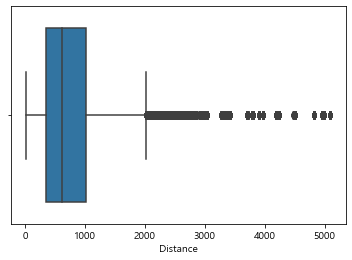

In [53]:
_ = sns.boxplot(data=train, x='Distance')

<AxesSubplot:>

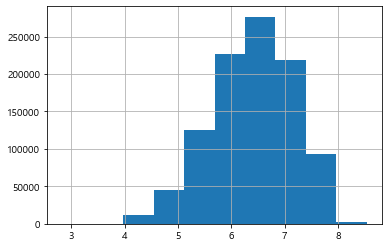

In [54]:
np.log1p(train['Distance']).hist()

In [55]:
train['Distance_log1p'] = np.log1p(train['Distance'])
test['Distance_log1p'] = np.log1p(test['Distance'])

In [56]:
train = train.drop(['Distance'],axis=1)
test = test.drop(['Distance'],axis=1)

- Airline, Carrier_Code(IATA, DOT) 결측치 채우기

In [57]:
na_cols = ['Airline','Carrier_Code(IATA)','Carrier_ID(DOT)']
for col in na_cols:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    test[col] = test[col].fillna(mode)

In [58]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Distance_log1p
0,4,15,6,0,19,0,OKC,Oklahoma,HOU,Texas,Southwest Airlines Co.,WN,19393.0,N7858A,None,6.040255
1,8,15,7,40,10,24,ORD,Illinois,SLC,Utah,SkyWest Airlines Inc.,UA,20304.0,N125SY,None,7.131699
2,9,6,16,10,18,5,CLT,North Carolina,LGA,New York,American Airlines Inc.,AA,19805.0,N103US,None,6.300786
3,7,10,9,5,17,35,LAX,California,EWR,New Jersey,United Air Lines Inc.,UA,19393.0,N595UA,None,7.805882
4,1,11,9,0,10,19,SFO,California,ACV,California,SkyWest Airlines Inc.,UA,20304.0,N161SY,None,5.525453


In [59]:
train.isna().sum()

Month                            0
Day_of_Month                     0
Estimated_Departure_Hour         0
Estimated_Departure_Min          0
Estimated_Arrival_Hour           0
Estimated_Arrival_Min            0
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Airline                          0
Carrier_Code(IATA)               0
Carrier_ID(DOT)                  0
Tail_Number                      0
Delay                       744999
Distance_log1p                   0
dtype: int64

2. 예측에 도움되는 피쳐 고르기
- Month, Day_of_Month, Estimated_Departure_Hour, Estimated_Departure_Min, Estimated_Arrival_Hour, Estimated_Arrival_Min, Origin_State, Destination_State,  Carrier_Code(IATA)(etc 처리), Distance_log1p
- Origin_Airport, Destination_Airport, Tail_Number 드랍
- Airline, Carrier_ID(DOT)는 일단 실행해보고 보류

In [60]:
train.nunique()

Month                         12
Day_of_Month                  31
Estimated_Departure_Hour      24
Estimated_Departure_Min       60
Estimated_Arrival_Hour        25
Estimated_Arrival_Min         60
Origin_Airport               374
Origin_State                  52
Destination_Airport          375
Destination_State             52
Airline                       28
Carrier_Code(IATA)            11
Carrier_ID(DOT)               28
Tail_Number                 6430
Delay                          2
Distance_log1p              1597
dtype: int64

In [61]:
train = train.drop(['Origin_Airport','Destination_Airport','Tail_Number'], axis=1)
test = test.drop(['Origin_Airport','Destination_Airport','Tail_Number'], axis=1)

Carrier_Code(IATA) column 비율 낮은 카테고리 기타 처리

In [62]:
cc_low_count = (train['Carrier_Code(IATA)'].value_counts(normalize=True) < 0.1)
low_rate_cc = cc_low_count[cc_low_count].index

In [63]:
low_rate_cc

Index(['AS', 'B6', 'NK', 'F9', 'G4', 'HA', 'VX'], dtype='object')

In [64]:
for cc in low_rate_cc:
    train.loc[train['Carrier_Code(IATA)'] == cc, 'Carrier_Code(IATA)'] ='etc'
    test.loc[test['Carrier_Code(IATA)'] == cc, 'Carrier_Code(IATA)'] = 'etc'

In [65]:
only_test_cc = set(test['Carrier_Code(IATA)'].unique()) - set(train['Carrier_Code(IATA)'].unique())
only_test_cc

{'9E', 'EV', 'MQ', 'OH', 'OO', 'YV', 'YX'}

In [66]:
for cc in only_test_cc:
    test.loc[test['Carrier_Code(IATA)'] == cc, 'Carrier_Code(IATA)'] = 'etc'

In [67]:
train['Carrier_Code(IATA)'].value_counts(normalize=True)

UA     0.315201
WN     0.182189
AA     0.182099
DL     0.161266
etc    0.159245
Name: Carrier_Code(IATA), dtype: float64

In [68]:
test['Carrier_Code(IATA)'].value_counts(normalize=True)

UA     0.309167
AA     0.182635
WN     0.179818
etc    0.175695
DL     0.152685
Name: Carrier_Code(IATA), dtype: float64

Airline 비율 낮은 카테고리 기타 처리

In [69]:
train['Airline'].value_counts(normalize=True)


Southwest Airlines Co.                       0.291033
Delta Air Lines Inc.                         0.089750
SkyWest Airlines Inc.                        0.086867
United Air Lines Inc.                        0.084070
American Airlines Inc.                       0.082755
JetBlue Airways                              0.041643
Republic Airlines                            0.033582
Alaska Airlines Inc.                         0.029141
Envoy Air                                    0.027455
Spirit Air Lines                             0.024998
Comair Inc.                                  0.024723
Mesa Airlines Inc.                           0.024679
Endeavor Air Inc.                            0.023172
ExpressJet Airlines Inc.                     0.020144
Frontier Airlines Inc.                       0.017415
Allegiant Air                                0.013667
Air Wisconsin Airlines Corp                  0.013400
Horizon Air                                  0.013087
Hawaiian Airlines Inc.      

In [70]:
train['Airline'].value_counts(normalize=True)[
    train['Airline'].value_counts(normalize=True) > 0.03].sum()

0.7097

In [71]:
airline_low_count = (train['Airline'].value_counts(normalize=True) < 0.03)
low_rate_airline = airline_low_count[airline_low_count].index

In [72]:
low_rate_airline

Index(['Alaska Airlines Inc.', 'Envoy Air', 'Spirit Air Lines', 'Comair Inc.',
       'Mesa Airlines Inc.', 'Endeavor Air Inc.', 'ExpressJet Airlines Inc.',
       'Frontier Airlines Inc.', 'Allegiant Air',
       'Air Wisconsin Airlines Corp', 'Horizon Air', 'Hawaiian Airlines Inc.',
       'Capital Cargo International',
       'GoJet Airlines, LLC d/b/a United Express', 'Trans States Airlines',
       'Compass Airlines', 'Commutair Aka Champlain Enterprises, Inc.',
       'Virgin America', 'Empire Airlines Inc.', 'Peninsula Airways Inc.',
       'Cape Air'],
      dtype='object')

In [73]:
for cc in low_rate_airline:
    train.loc[train['Airline'] == cc, 'Airline'] = 'etc'
    test.loc[test['Airline'] == cc, 'Airline'] = 'etc'

In [74]:
only_test_al = set(test['Airline'].unique()) - set(train['Airline'].unique())
only_test_al

set()

In [75]:
train['Airline'].value_counts(normalize=True)

Southwest Airlines Co.    0.291033
etc                       0.290300
Delta Air Lines Inc.      0.089750
SkyWest Airlines Inc.     0.086867
United Air Lines Inc.     0.084070
American Airlines Inc.    0.082755
JetBlue Airways           0.041643
Republic Airlines         0.033582
Name: Airline, dtype: float64

In [76]:
test['Airline'].value_counts(normalize=True)

etc                       0.291113
Southwest Airlines Co.    0.289785
Delta Air Lines Inc.      0.086363
American Airlines Inc.    0.086056
SkyWest Airlines Inc.     0.085650
United Air Lines Inc.     0.083733
JetBlue Airways           0.044116
Republic Airlines         0.033184
Name: Airline, dtype: float64

Carrier_ID(DOT) column 비율 낮은 카테고리 기타 처리

In [77]:
train['Carrier_ID(DOT)'].value_counts(normalize=True)

19393.0    0.291022
19790.0    0.089958
20304.0    0.086902
19977.0    0.083984
19805.0    0.082860
20409.0    0.041615
20452.0    0.033351
19930.0    0.029085
20398.0    0.027474
20416.0    0.024983
20397.0    0.024838
20378.0    0.024699
20363.0    0.023113
20366.0    0.020197
20436.0    0.017440
20368.0    0.013739
20046.0    0.013319
19687.0    0.013107
19690.0    0.010921
20427.0    0.009962
20500.0    0.009532
20237.0    0.009321
21167.0    0.008813
20445.0    0.007124
21171.0    0.001324
20263.0    0.001052
20225.0    0.000142
20253.0    0.000123
Name: Carrier_ID(DOT), dtype: float64

In [78]:
train['Carrier_ID(DOT)'].value_counts(normalize=True)[
    train['Carrier_ID(DOT)'].value_counts(normalize=True) > 0.03].sum()

0.709692

In [79]:
ci_low_count = (train['Carrier_ID(DOT)'].value_counts(normalize=True) < 0.03)
low_rate_ci = ci_low_count[ci_low_count].index

In [80]:
low_rate_ci


Float64Index([19930.0, 20398.0, 20416.0, 20397.0, 20378.0, 20363.0, 20366.0,
              20436.0, 20368.0, 20046.0, 19687.0, 19690.0, 20427.0, 20500.0,
              20237.0, 21167.0, 20445.0, 21171.0, 20263.0, 20225.0, 20253.0],
             dtype='float64')

In [81]:
for cc in low_rate_ci:
    train.loc[train['Carrier_ID(DOT)'] == cc, 'Carrier_ID(DOT)'] = 30000.0
    test.loc[test['Carrier_ID(DOT)'] == cc, 'Carrier_ID(DOT)'] = 30000.0

In [82]:
only_test_ci = set(test['Carrier_ID(DOT)'].unique()) - set(train['Carrier_ID(DOT)'].unique())
only_test_ci

set()

In [83]:
train['Carrier_ID(DOT)'].value_counts(normalize=True)

19393.0    0.291022
30000.0    0.290308
19790.0    0.089958
20304.0    0.086902
19977.0    0.083984
19805.0    0.082860
20409.0    0.041615
20452.0    0.033351
Name: Carrier_ID(DOT), dtype: float64

In [84]:
test['Carrier_ID(DOT)'].value_counts(normalize=True)

30000.0    0.290554
19393.0    0.288916
19805.0    0.087875
19790.0    0.086309
20304.0    0.086241
19977.0    0.082990
20409.0    0.044001
20452.0    0.033114
Name: Carrier_ID(DOT), dtype: float64

#### Categorical columns Labeling

In [85]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_State,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Delay,Distance_log1p
0,4,15,6,0,19,0,Oklahoma,Texas,Southwest Airlines Co.,WN,19393.0,None,6.040255
1,8,15,7,40,10,24,Illinois,Utah,SkyWest Airlines Inc.,UA,20304.0,None,7.131699
2,9,6,16,10,18,5,North Carolina,New York,American Airlines Inc.,AA,19805.0,None,6.300786
3,7,10,9,5,17,35,California,New Jersey,United Air Lines Inc.,UA,19393.0,None,7.805882
4,1,11,9,0,10,19,California,California,SkyWest Airlines Inc.,UA,20304.0,None,5.525453


In [86]:
train.columns

Index(['Month', 'Day_of_Month', 'Estimated_Departure_Hour',
       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
       'Estimated_Arrival_Min', 'Origin_State', 'Destination_State', 'Airline',
       'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Delay', 'Distance_log1p'],
      dtype='object')

In [87]:
cate_cols = ['Origin_State', 'Destination_State','Airline',
       'Carrier_Code(IATA)', 'Carrier_ID(DOT)']

In [88]:
for col in cate_cols:
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

In [89]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_State,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Delay,Distance_log1p
0,4,15,6,0,19,0,34,42,5,3,0,None,6.040255
1,8,15,7,40,10,24,11,45,4,2,4,None,7.131699
2,9,6,16,10,18,5,31,30,0,0,2,None,6.300786
3,7,10,9,5,17,35,4,28,6,2,0,None,7.805882
4,1,11,9,0,10,19,4,4,4,2,4,None,5.525453


In [90]:
test.head()

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_State,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Delay,Distance_log1p
0,12,16,11,56,19,0,42,42,6,2,0,NaN,5.257495
1,9,12,15,0,17,15,28,8,1,1,1,NaN,6.616065
2,3,6,16,0,19,15,11,30,6,2,3,NaN,6.598509
3,5,18,19,20,20,45,4,4,5,3,0,NaN,5.823046
4,7,7,19,15,21,52,7,4,2,4,5,NaN,7.759614


### 준지도학습

#### labeling된 train data 추출

In [91]:
labeled_train = train.dropna()
labeled_train

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_State,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Delay,Distance_log1p
5,4,13,15,45,19,0,28,47,3,2,6,Not_Delayed,5.298317
6,1,20,17,42,19,3,28,19,6,2,0,Not_Delayed,5.303305
8,6,13,14,20,15,50,18,31,5,3,0,Not_Delayed,5.891644
10,8,13,17,30,18,44,47,36,3,0,0,Delayed,5.323010
12,1,12,10,15,11,45,33,5,5,3,0,Not_Delayed,7.091742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999962,10,11,6,0,20,3,42,11,4,2,4,Not_Delayed,6.948897
999963,5,2,17,59,19,26,30,47,5,1,6,Delayed,5.370638
999969,10,10,9,40,10,56,42,42,7,2,7,Delayed,5.758902
999985,8,8,19,14,20,39,31,7,7,4,7,Not_Delayed,6.011267


In [92]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i

column_number

{'Not_Delayed': 0, 'Delayed': 1}

In [93]:
labeled_train['Delay'] = labeled_train['Delay'].map(column_number)

<ipython-input-93-2b69c87db1c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_train['Delay'] = labeled_train['Delay'].map(column_number)


In [94]:
unlabeled_train = train[train['Delay'].isna()]
unlabeled_train

,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_State,Destination_State,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Delay,Distance_log1p
0,4,15,6,0,19,0,34,42,5,3,0,None,6.040255
1,8,15,7,40,10,24,11,45,4,2,4,None,7.131699
2,9,6,16,10,18,5,31,30,0,0,2,None,6.300786
3,7,10,9,5,17,35,4,28,6,2,0,None,7.805882
4,1,11,9,0,10,19,4,4,4,2,4,None,5.525453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,18,9,36,12,43,11,36,6,2,3,None,6.520621
999996,5,30,9,20,10,28,32,21,4,1,0,None,5.411646
999997,6,28,8,0,13,40,4,42,5,3,0,None,7.404279
999998,9,27,16,13,18,24,41,8,1,1,1,None,5.370638


In [95]:
labeled_X_train = labeled_train.drop(['Delay'],axis=1)
labeled_y_train = labeled_train['Delay']

In [96]:
unlabeled_X_train = unlabeled_train.drop(['Delay'], axis=1)

##### 모델링

In [97]:
RF_model = RandomForestClassifier(n_estimators=500, random_state=42)

In [98]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

In [99]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [100]:
scores = cross_val_score(
    RF_model, labeled_X_train, labeled_y_train, cv=kf, n_jobs=-1,
    scoring='neg_log_loss'
)
scores


array([-0.45952336, -0.45351602, -0.45724174, -0.45747537, -0.45079692])

In [101]:
y_valid_predict = cross_val_predict(
    RF_model, labeled_X_train, labeled_y_train, cv=5, n_jobs=-1)
y_valid_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [102]:
(y_valid_predict == labeled_y_train).mean()

0.8189340433959083

In [109]:
from sklearn.metrics import r2_score
r2_score(labeled_y_train, y_valid_predict)

-0.24591006413196936

##### 준지도학습X.ver

In [104]:
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(labeled_X_train, labeled_y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [112]:
X_test = test.drop(['Delay'],axis=1)

In [113]:
y_pred = clf.predict_proba(X_test)
y_pred


array([[0.676, 0.324],
       [0.67 , 0.33 ],
       [0.402, 0.598],
       ...,
       [0.83 , 0.17 ],
       [0.86 , 0.14 ],
       [0.93 , 0.07 ]])

In [114]:
submission = pd.DataFrame(
    data=y_pred, columns=sample_submission.columns, index=sample_submission.index)

In [115]:
submission

,Not_Delayed,Delayed
ID,,
TEST_000000,0.676,0.324
TEST_000001,0.670,0.330
TEST_000002,0.402,0.598
TEST_000003,0.568,0.432
TEST_000004,0.652,0.348
...,...,...
TEST_999995,0.560,0.440
TEST_999996,0.876,0.124
TEST_999997,0.830,0.170


In [116]:
submission.to_csv('./submissions/baseline_submission_230421.csv', index=True)

##### 준지도학습O.ver

In [104]:
len(y_valid_predict)

255001

In [110]:
unlabeled_y_train = RF_model.fit(labeled_X_train,labeled_y_train).predict(unlabeled_X_train)
unlabeled_y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [111]:
len(unlabeled_y_train)

744999